In [1]:
import os
dirname = r"..\Dataset"
os.listdir(dirname)

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, test = False, simplified = False):
        self.img_dir = img_dir
        self.label_dirs = os.listdir(img_dir)
        self.filenames = []
        self.labels = []
        label_c = -1
        for label_dir in self.label_dirs:
          label_c = label_c + 1
          full_dir = os.path.join(img_dir, label_dir)
          files = os.listdir(full_dir)
          for file in files:
            if "frame" in file and test:
              full_filename = os.path.join(full_dir, file)
              self.filenames.append(full_filename)
              self.labels.append(label_c)
            elif "frame" not in file and not test:
              full_filename = os.path.join(full_dir, file)
              self.filenames.append(full_filename)
              self.labels.append(label_c)
            
        #happy is 4 and neutral is 5 and surprise is 7
        if simplified:
            for i in range(len(self.labels)):
                if (self.labels[i] == 4) or (self.labels[i] == 7):
                    self.labels[i] = 0
                elif (self.labels[i] == 5):
                    self.labels[i] = 1
                else:
                    self.labels[i] = 2
            self.label_dirs = ["positive", "neutral", "negative"]
        return

    def transform(self, image):
      return image

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = np.array(Image.open(img_path).resize((200,150))).astype(float)/255
        #image = image[:,:,0] + image[:,:,1] + image[:,:,2]
        image = image.transpose((2, 0, 1))
        image = torch.Tensor(image)
        label = self.labels[idx]
        label = torch.Tensor([label])[0].type(torch.LongTensor)
        return image, label, img_path

In [4]:
#make the training and testing sets
simplified = True
train_dataset = ImageDataset(dirname, test = False, simplified = simplified)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = ImageDataset(dirname, test = True, simplified = simplified)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

print("Num training images:", len(train_dataset))
print("Num testing images:", len(test_dataset))
print()

num_classes = len(train_dataset.label_dirs)

print("Training distribution:")
LL = []
for images, labels, filenames in train_loader:
    for label in labels:
        L = label.item()
        LL.append(L)
for i in range(num_classes):
    print(train_loader.dataset.label_dirs[i], ":", LL.count(i))
print()

print("Testing distribution:")
LL = []
for images, labels, filenames in test_loader:
    for label in labels:
        L = label.item()
        LL.append(L)
for i in range(num_classes):
    print(train_loader.dataset.label_dirs[i], ":", LL.count(i))

Num training images: 170
Num testing images: 30

Training distribution:
positive : 41
neutral : 48
negative : 81

Testing distribution:
positive : 9
neutral : 10
negative : 11


In [5]:
#make the model
device = "cuda"
model = models.resnet50()
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, num_classes),
                                 nn.LogSoftmax(dim=1))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
pass

Epoch 9 :
	Loss =  89.75235658884048 ; time: 3.8110013008117676
Epoch 19 :
	Loss =  89.65952837467194 ; time: 3.5840003490448
Epoch 29 :
	Loss =  89.61321914196014 ; time: 4.003998756408691
Epoch 39 :
	Loss =  89.59251964092255 ; time: 4.059998273849487
Epoch 49 :
	Loss =  89.63052535057068 ; time: 3.702000617980957
Average time per epoch: 3.883430280685425


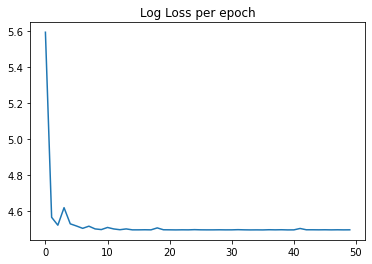

In [6]:
epochs = 50
train_losses = []
model.train()
avg_time = 0
for epoch in range(epochs):
  start = time.time()
  epoch_loss = 0
  for images, labels, filenames in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    pred = model.forward(images)
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()

    epoch_loss = epoch_loss + loss.item()
  end = time.time()
  epoch_time = end - start
  avg_time = avg_time + epoch_time
  if (epoch+1)%10 == 0:
    print("Epoch",epoch,":")
    print("\tLoss = ", epoch_loss,"; time:", epoch_time)
  train_losses.append(epoch_loss)

torch.save(model, 'images2emotions.pth')
print("Average time per epoch:", avg_time/epochs)

plt.plot(np.log(train_losses))
plt.title("Log Loss per epoch")
plt.show()

In [7]:
torch.load("images2emotions.pth")
model.eval()
correct = {}
total = {}
for label in range(num_classes):
    correct[label] = 0
    total[label] = 0
correct_num = 0
total_num = 0
    
for images, labels, filenames in test_loader:
  images = images.to(device)
  labels = labels.to(device)
  pred = model.forward(images)[0,:].detach().cpu().numpy()
  guess = np.argmax(pred)
  label = labels[0].item()
  if guess == label:
    correct[label] = correct[label] + 1
    correct_num = correct_num + 1
  total[label] = total[label] + 1
  total_num = total_num + 1

print("Class Accuracies:")
names = ["Positive", "Neutral", "Negative"]
for label in range(num_classes):
    print(names[label],":",correct[label]*100/total[label], "% right")
print("\nTotal Accuracies:")
print("\t",correct_num*100/total_num, "% right")

Class Accuracies:
Positive : 0.0 % right
Neutral : 0.0 % right
Negative : 100.0 % right

Total Accuracies:
	 36.666666666666664 % right
